<a href="https://colab.research.google.com/github/RaihanFazzaufaR/22_RaihanFazzaufaRasendriya/blob/main/Week9_tugas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

# Tugas


# Penghapusan Background (Masking)

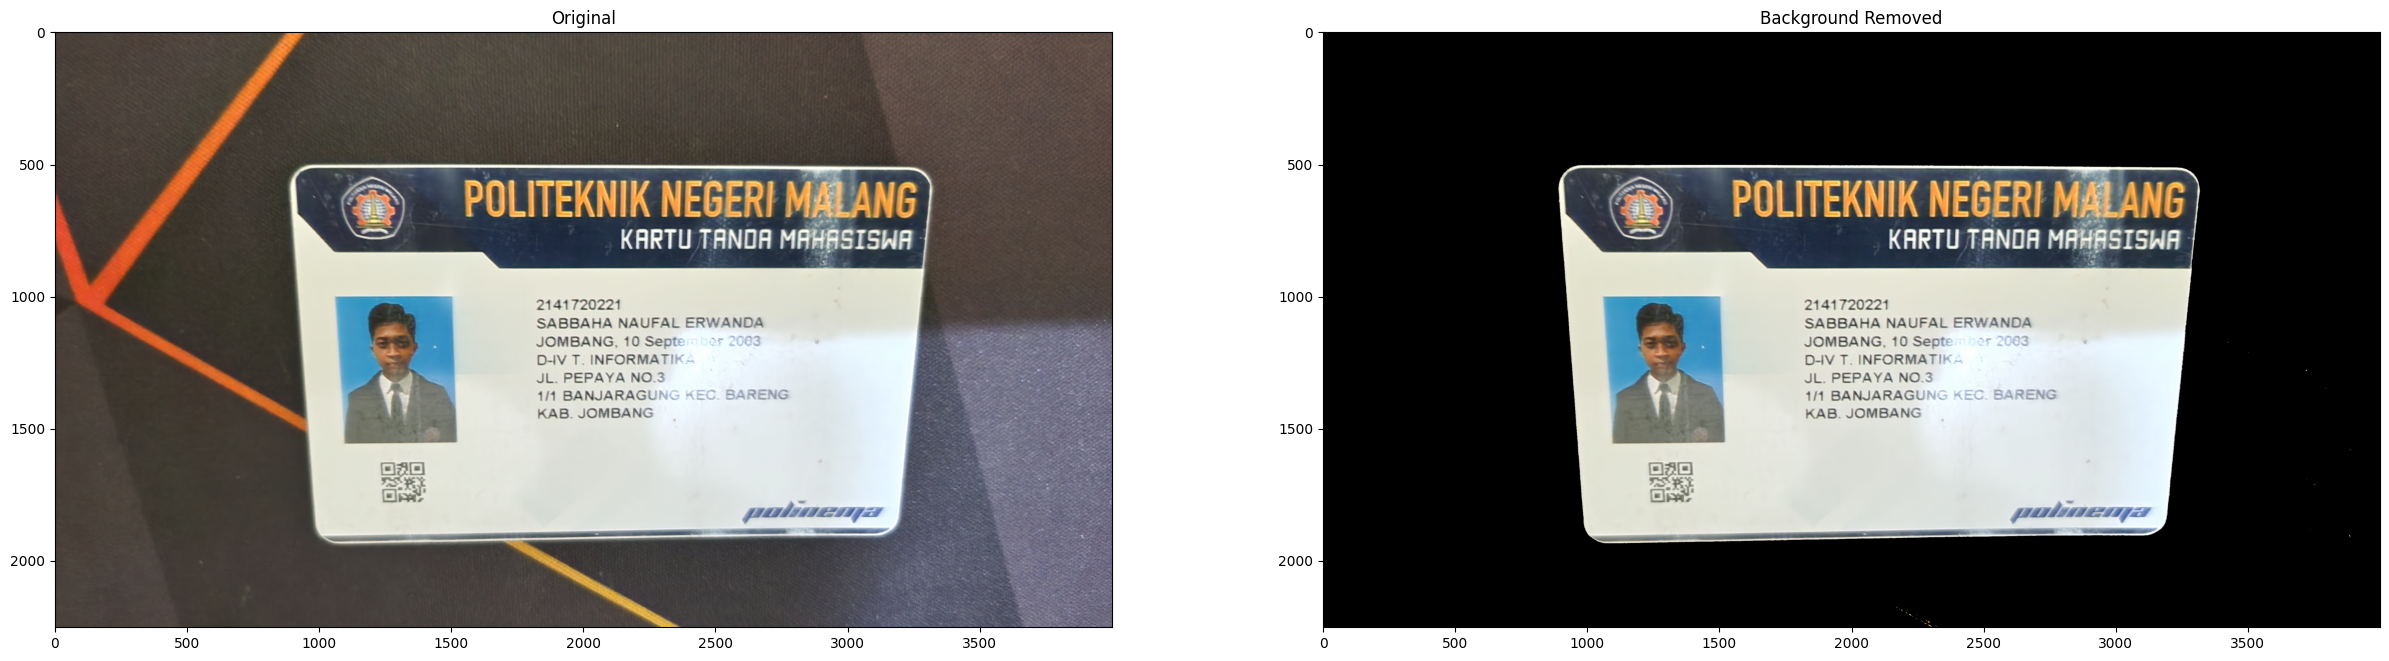

In [3]:
image_original = cv.imread('/content/drive/MyDrive/PCVK/Images/3A_2141720221_4 - Sabbaha Naufal.jpg')
image = cv.cvtColor(image_original, cv.COLOR_BGR2RGB)

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

_, thresh = cv.threshold(gray, 190, 255, cv.THRESH_BINARY)

contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(image)

cv.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv.FILLED)

img_backgroundremove = cv.bitwise_and(image, mask)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(img_backgroundremove)
plt.title("Background Removed")
plt.show()

# Crop Image

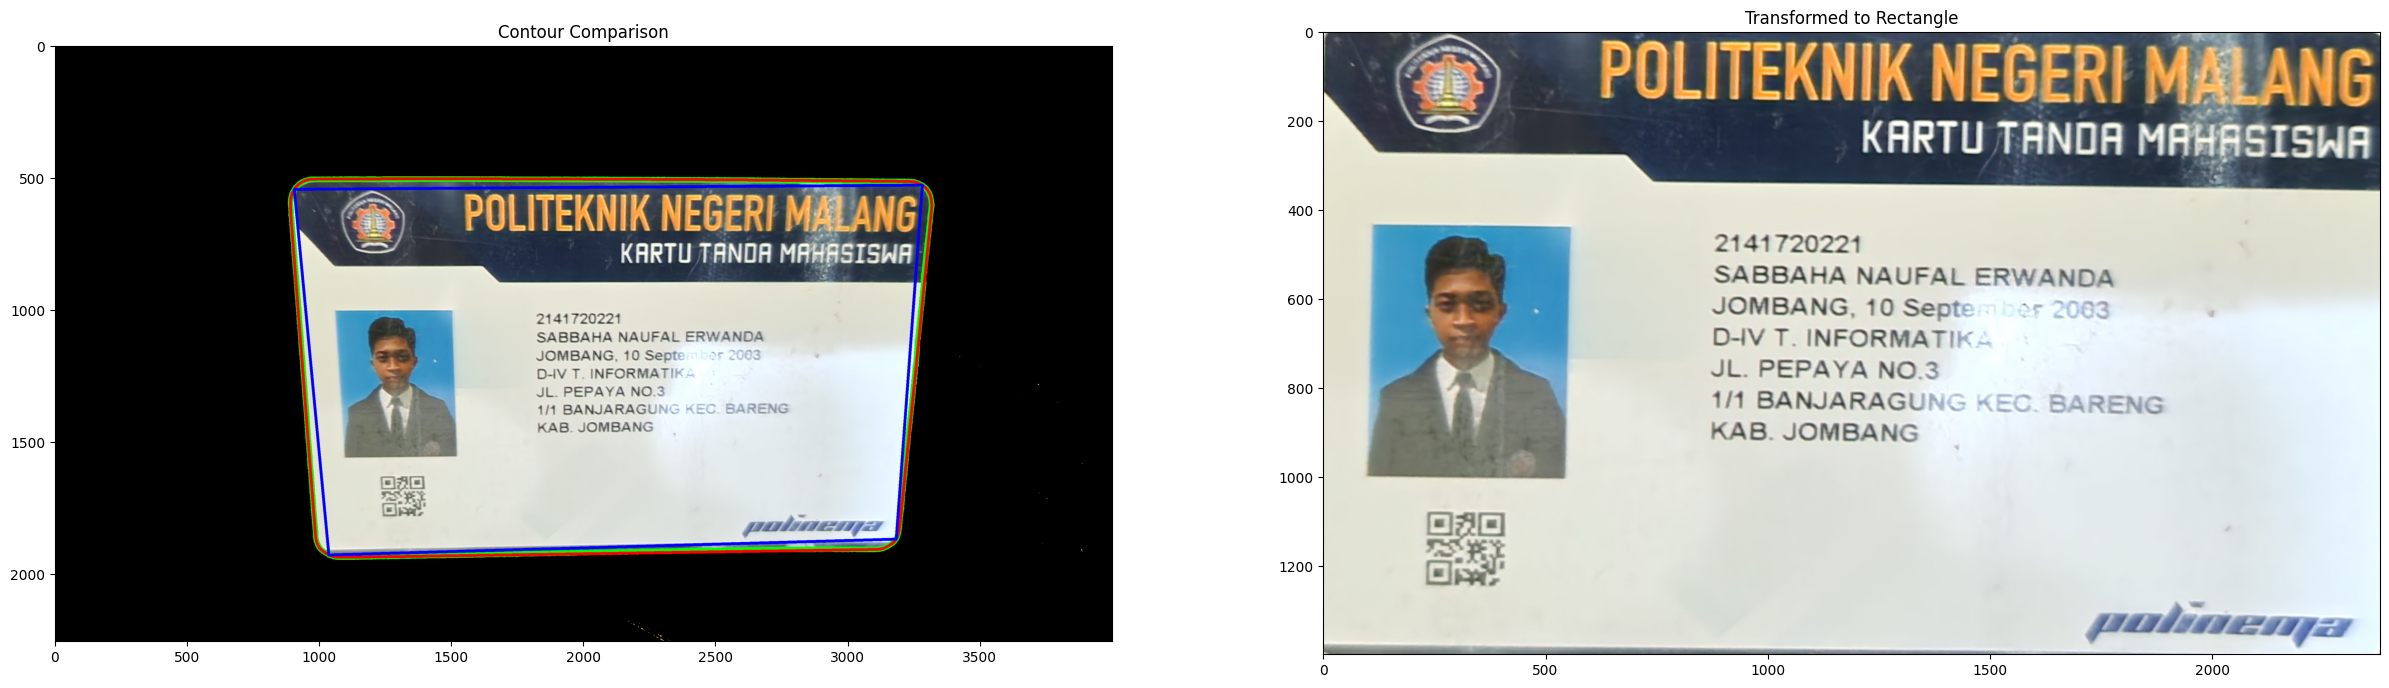

In [4]:
largest_contour = max(contours, key=cv.contourArea)

hull = cv.convexHull(largest_contour)

epsilon = 0.05 * cv.arcLength(hull, True)
approx = cv.approxPolyDP(hull, epsilon, True)

image_with_contours = img_backgroundremove.copy()
cv.drawContours(image_with_contours, [largest_contour], -1, (0, 255, 0), 20)  # Kontur asli (largest)
cv.drawContours(image_with_contours, [hull], -1, (255, 0, 0), 10)  # Kontur cembungan (hull)
cv.drawContours(image_with_contours, [approx], -1, (0, 0, 255), 10)  # Kontur sudut (approx)

if len(approx) == 4:
  trapezium_points = np.array([approx[0][0], approx[1][0], approx[2][0], approx[3][0]], dtype=np.float32)

  x_min = np.min(trapezium_points[:, 0])
  x_max = np.max(trapezium_points[:, 0])
  y_min = np.min(trapezium_points[:, 1])
  y_max = np.max(trapezium_points[:, 1])

  # print(trapezium_points)
  # print(x_min, x_max, y_min, y_max)
  # print(x_max - x_min, y_max - y_min)

  rect_width = int(x_max - x_min)  #2377
  rect_height = int(y_max - y_min) #1400
  rect_points = np.array([[0, 0], [rect_width, 0], [rect_width, rect_height], [0, rect_height]], dtype=np.float32)
  matrix = cv.getPerspectiveTransform(trapezium_points, rect_points)
  warped_img = cv.warpPerspective(img_backgroundremove, matrix, (rect_width, rect_height))

  plt.figure(figsize=(30, 20))

  plt.subplot(1, 2, 1)
  plt.imshow(image_with_contours)
  plt.title("Contour Comparison")

  plt.subplot(1, 2, 2)
  plt.imshow(warped_img)
  plt.title("Transformed to Rectangle")

  plt.show()
else:
  print("Gambar tidak memiliki 4 sudut")

# RGB IMAGE

# Blurr Image (Denoising)

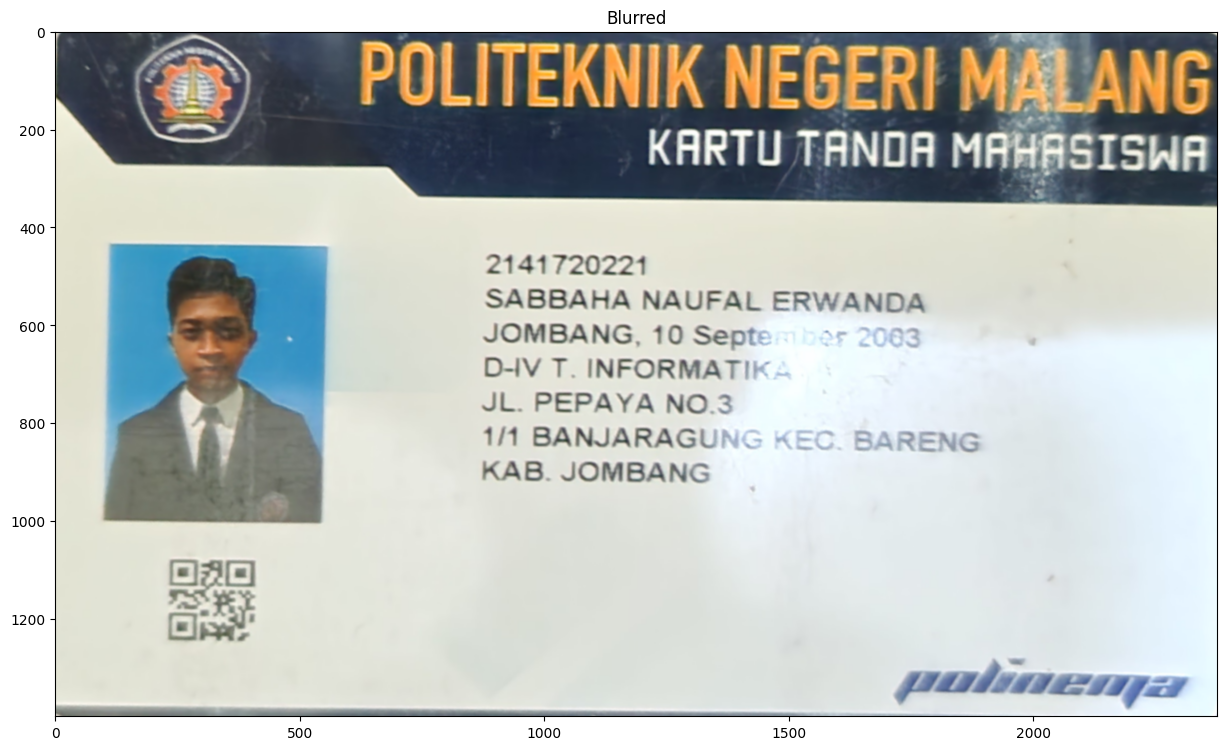

In [5]:
blurred_img = cv.GaussianBlur(warped_img, (5, 5), 0)

plt.figure(figsize=(15, 10))
plt.imshow(blurred_img)
plt.title("Blurred")
plt.show()

# Edge Detection

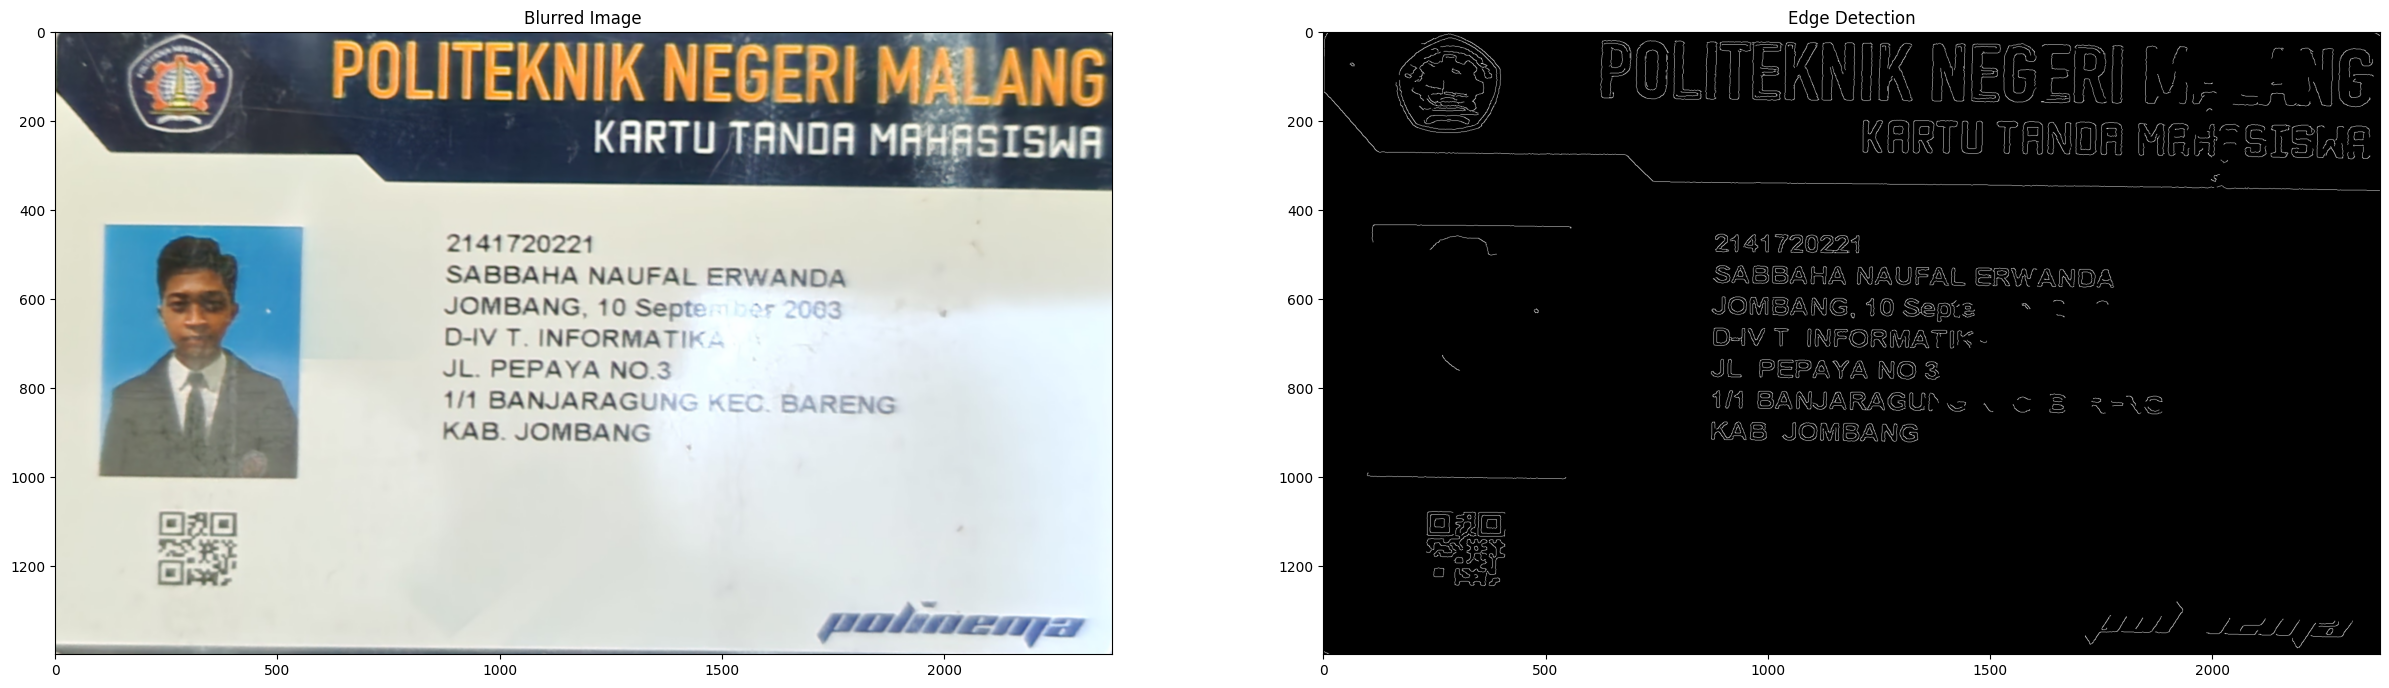

In [6]:
edges_detect = cv.Canny(blurred_img, 100, 200)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(blurred_img)
plt.title("Blurred Image")


plt.subplot(1, 2, 2)
plt.imshow(edges_detect, cmap='gray')
plt.title("Edge Detection")


plt.show()

# Brightness Adjustment

# Histogram Equalization (CLAHE)

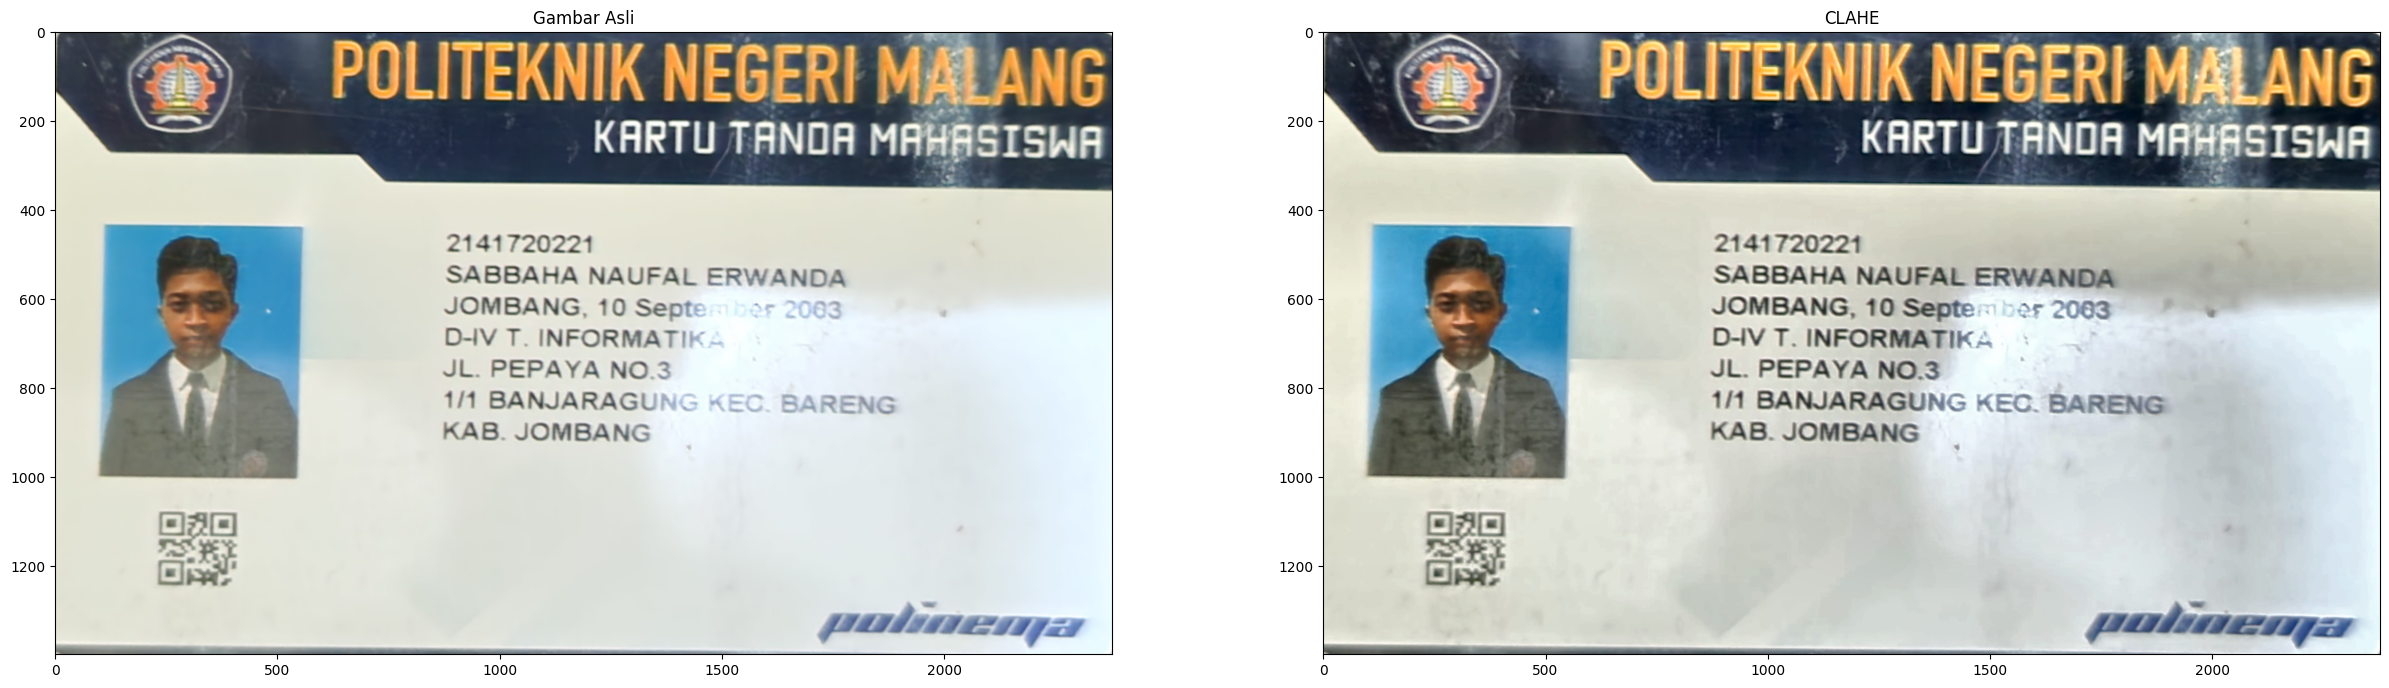

In [17]:
lab = cv.cvtColor(blurred_img.copy(), cv.COLOR_RGB2LAB)
l, a, b = cv.split(lab)

clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(6, 6))
cl = clahe.apply(l)

limg = cv.merge((cl, a, b))

clahe_img = cv.cvtColor(limg, cv.COLOR_LAB2RGB)

plt.figure(figsize=(30, 20))
plt.subplot(1,2,1)
plt.imshow(blurred_img)
plt.title('Gambar Asli')

plt.subplot(1,2,2)
plt.imshow(clahe_img)
plt.title('CLAHE')

plt.show()

# Operasi Aritmatika

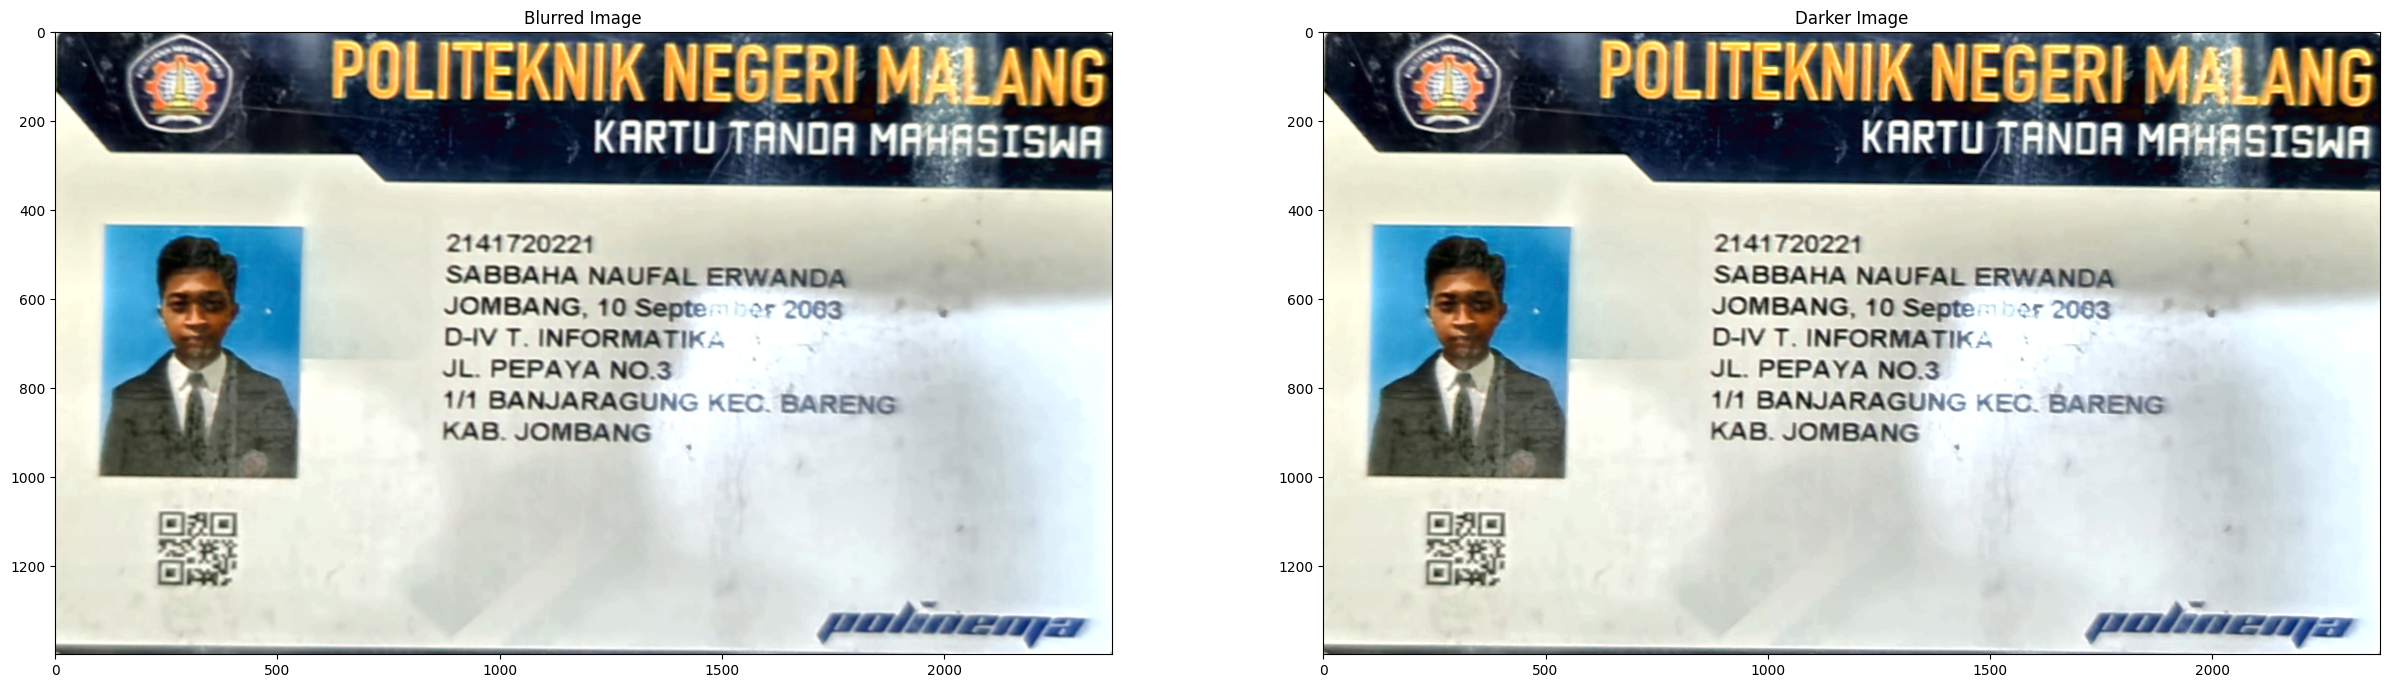

In [81]:
brightness_value = -30
brightness_img = cv.convertScaleAbs(clahe_img, alpha=1.2, beta=brightness_value)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(blurred_img)
plt.title("Blurred Image")

plt.subplot(1, 2, 2)
plt.imshow(brightness_img)
plt.title("Darker Image")
plt.show()

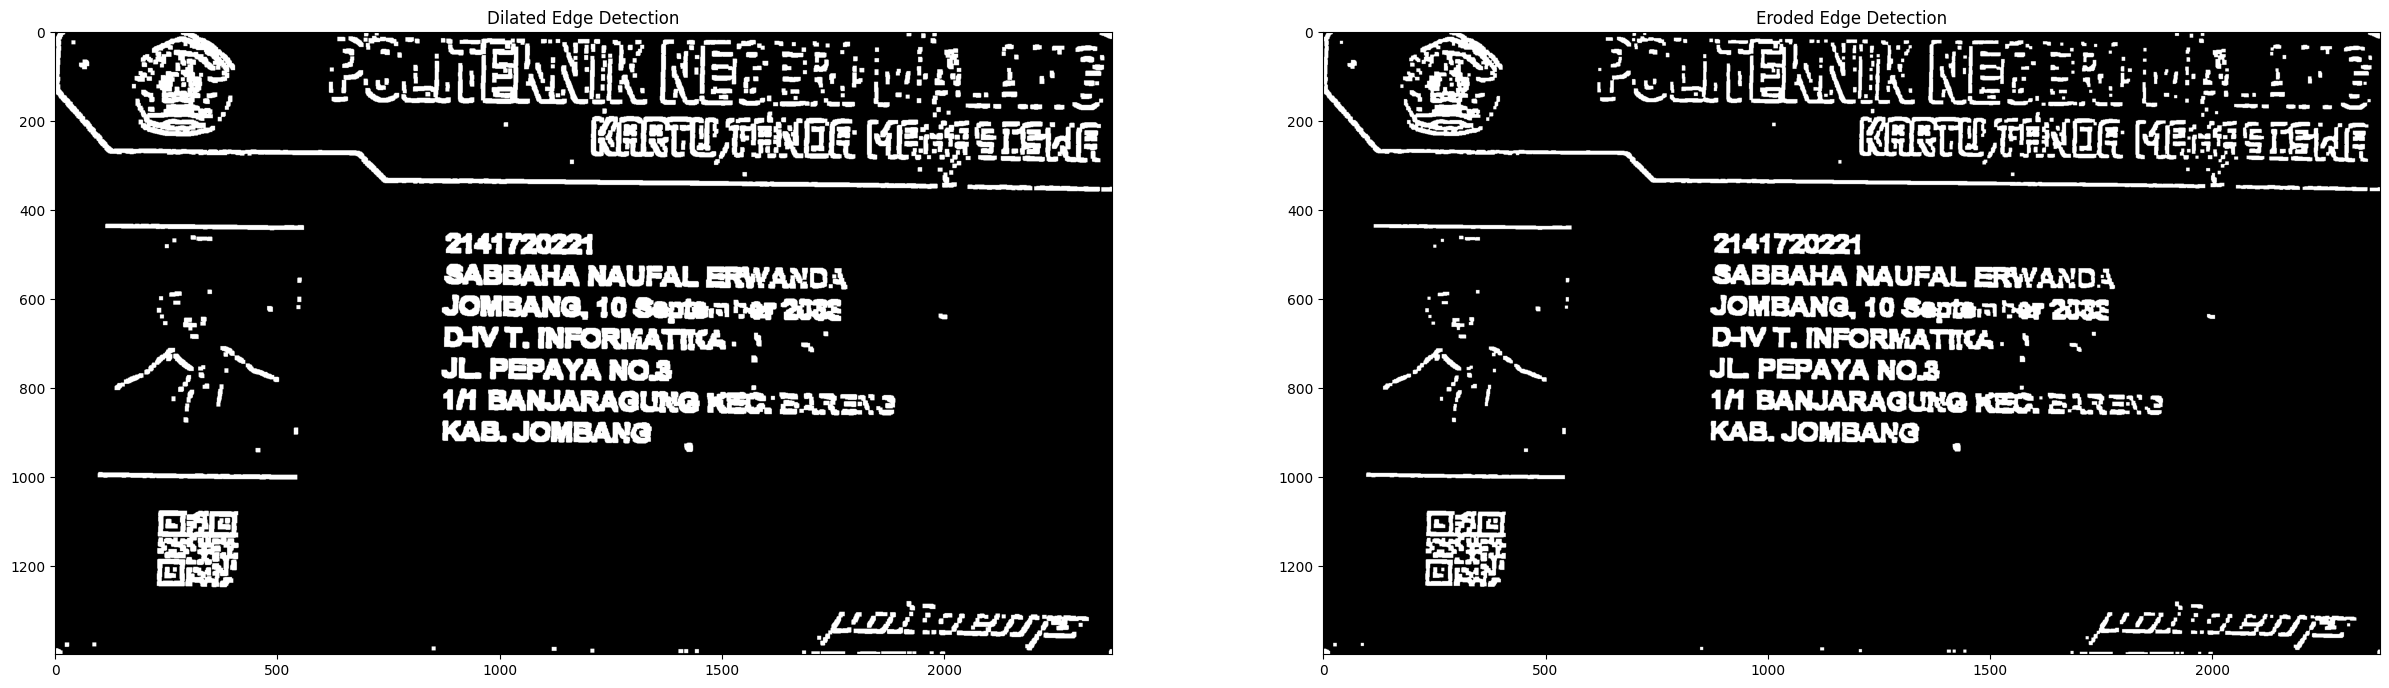

In [83]:
gray_image = cv.cvtColor(clahe_img, cv.COLOR_RGB2GRAY)
adaptive_thresh = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv.THRESH_BINARY_INV, blockSize=11, C=10)

square = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
cross = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
circle = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

dilated_img = cv.dilate(adaptive_thresh, square, iterations=4)

eroded_img = cv.erode(dilated_img, cross, iterations=1)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.imshow(dilated_img, cmap='gray')
plt.title("Dilated Edge Detection")

plt.subplot(1, 2, 2)
plt.imshow(eroded_img, cmap='gray')
plt.title("Eroded Edge Detection")
plt.show()